### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [ ]:
# Importing Libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [ ]:
# Counting the no. of train and test images
image_count_train = len(list(data_dir_train.glob('*/*.*')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
# Defining batch size, image height and width
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
# Creating training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Creating validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data

In [ ]:
# Import corresponding libraries
import matplotlib.pyplot as plt

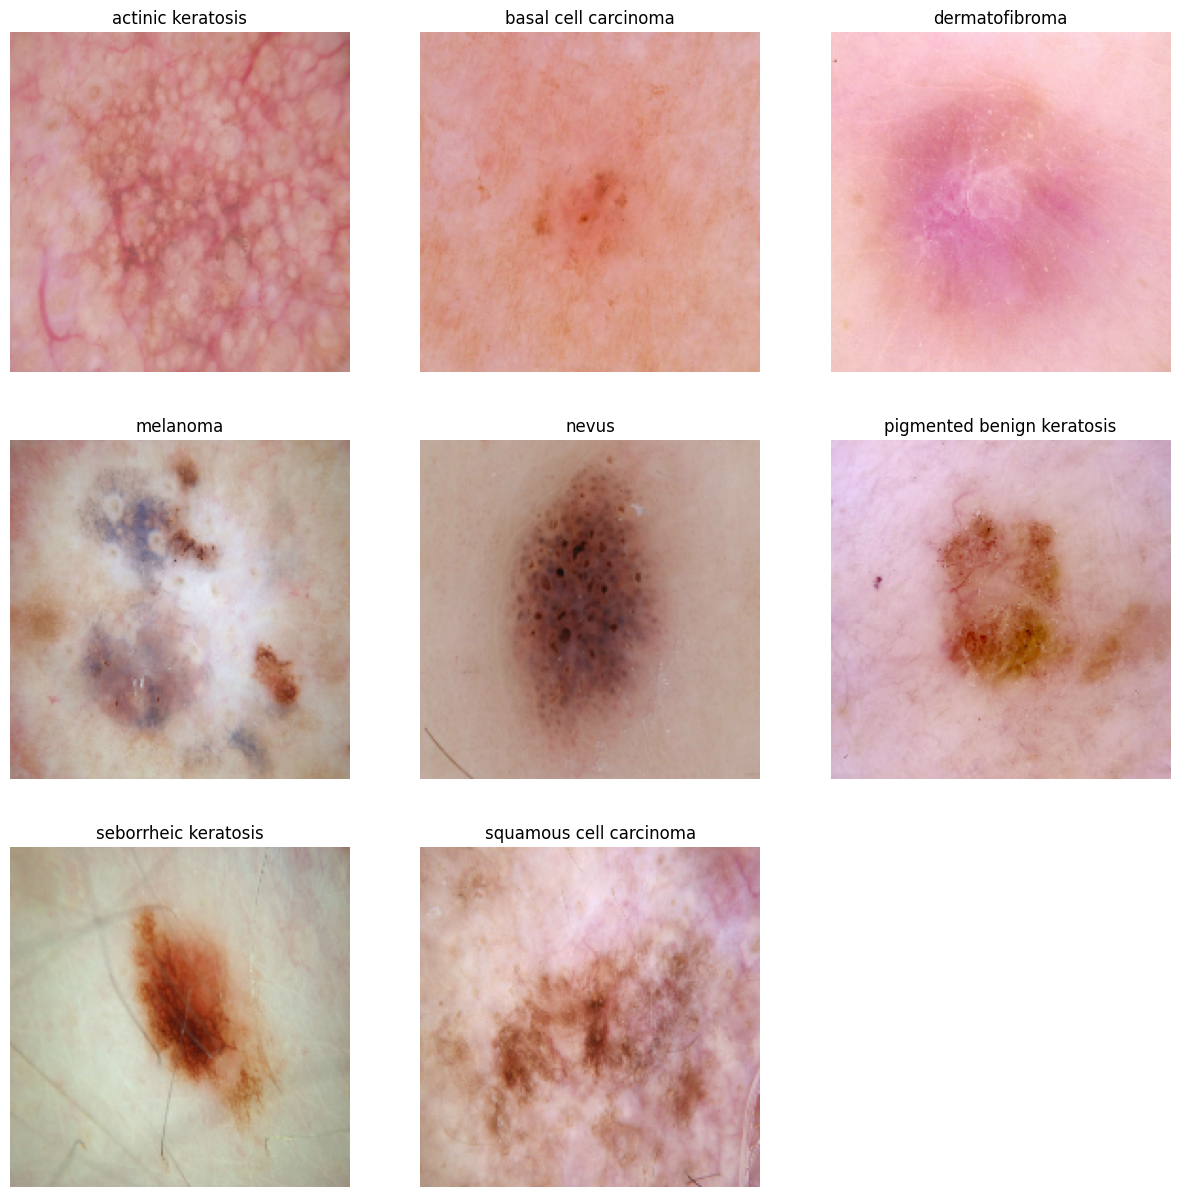

In [ ]:
# Visualizing one instance of each class
plt.figure(figsize=(15, 15))
for class_name in class_names:
  for images, labels in train_ds.take(1):
    for i in range(len(labels)):
      if class_names[labels[i]] == class_name:
        ax = plt.subplot(3, 3, class_names.index(class_name) + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis("off")
        break

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Defining Model #1
# Note - layers.experimental.preprocessing.Rescaling isn't working, so I have used simple rescaling from keras library
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(9, activation='softmax')  # Assuming there are 9 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │       1,327,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,390,185 (5.30 MB)

 Trainable params: 1,390,185 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 180ms/step - accuracy: 0.1981 - loss: 2.0799 - val_accuracy: 0.2662 - val_loss: 1.9128
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2674 - loss: 1.8963 - val_accuracy: 0.3266 - val_loss: 1.8573
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3518 - loss: 1.7868 - val_accuracy: 0.3803 - val_loss: 1.7188
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4033 - loss: 1.6833 - val_accuracy: 0.4855 - val_loss: 1.5391
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4452 - loss: 1.5661 - val_accuracy: 0.4720 - val_loss: 1.5122
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4700 - loss: 1.4815 - val_accuracy: 0.4720 - val_loss: 1.5314
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5133 - loss: 1.4030 - val_accuracy: 0.4966 - val_loss: 1.4863
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5119 - loss: 1.3618 - val_accuracy: 0.5190 - val_lo

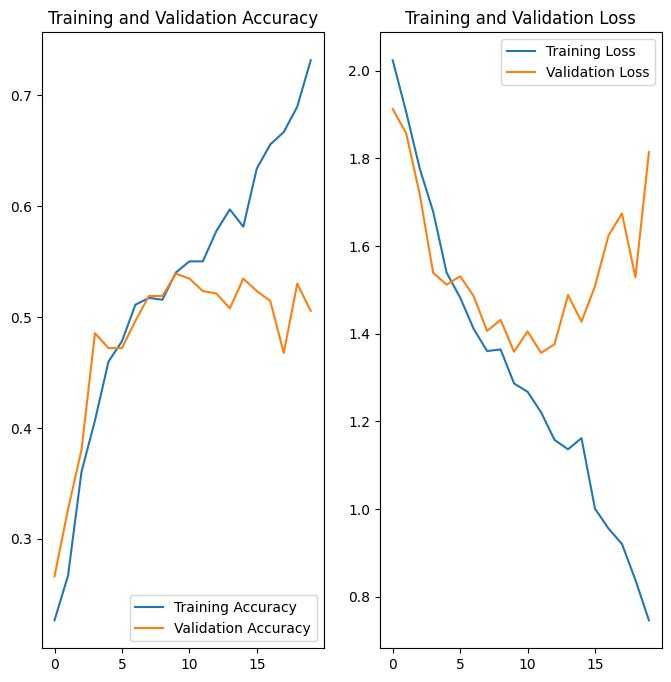

In [ ]:
# Visualizing Model Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Observations:
1. Overfitting: The gap between training and validation accuracy suggests that the model might be overfitting. The training accuracy is significantly higher than the validation accuracy, and the validation loss does not consistently decrease, indicating that the model is not generalizing well to the validation data.
2. Model Complexity: The model might be too complex for the given dataset, leading to overfitting. Simplifying the model or adding regularization techniques (like dropout or L2 regularization) could help improve generalization.
3. Learning Rate: The learning rate might need adjustment. If the learning rate is too high, the model might not converge properly, leading to fluctuations in validation loss. Experimenting with a lower learning rate or using a learning rate scheduler could help.
4. Data Augmentation: Implementing data augmentation techniques can help improve the model's ability to generalize by providing more varied training examples. This can reduce overfitting and improve validation performance.
5. Early Stopping: Using early stopping can prevent the model from overfitting by stopping the training process once the validation performance stops improving.

In [ ]:
# Enhanced data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
])

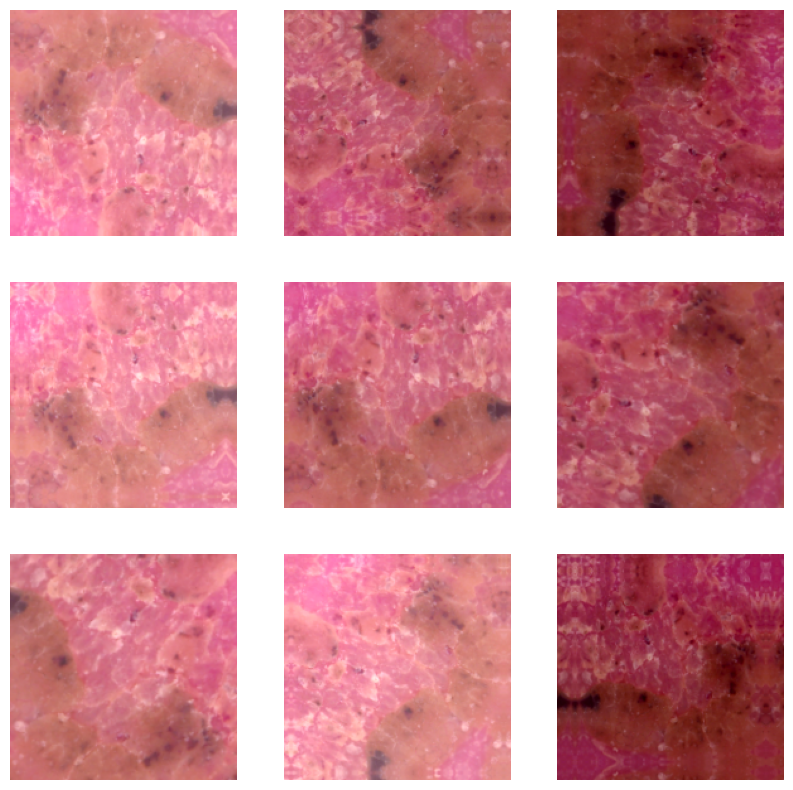

In [ ]:
# Function to visualize the augmentation strategy
def visualize_augmentation(dataset, data_augmentation):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_image = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_image[0].numpy().astype("uint8"))
            plt.axis("off")

# Visualize the augmentation strategy for one instance of training image
visualize_augmentation(train_ds, data_augmentation)

In [ ]:
# Define Model #2
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),  # Define the input shape
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(9, activation='softmax')  # Assuming there are 9 classes
])

In [ ]:
# Adjust the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
# Compile the model
model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Summary of the model
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_11 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │       1,327,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,390,185 (5.30 MB)

 Trainable params: 1,390,185 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define early stopping
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
# Train the model with early stopping
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    callbacks = [early_stopping]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1787 - loss: 2.0863 - val_accuracy: 0.1924 - val_loss: 2.0396
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2057 - loss: 2.0537 - val_accuracy: 0.2058 - val_loss: 2.0279
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2284 - loss: 2.0314 - val_accuracy: 0.3065 - val_loss: 2.0057
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2438 - loss: 2.0162 - val_accuracy: 0.3177 - val_loss: 1.9714
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2633 - loss: 1.9924 - val_accuracy: 0.3087 - val_loss: 1.9397
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2972 - loss: 1.9184 - val_accuracy: 0.3199 - val_loss: 1.8906
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3252 - loss: 1.8513 - val_accuracy: 0.3960 - val_loss: 1.7558
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3923 - loss: 1.7459 - val_accuracy: 0.4407 - val_los

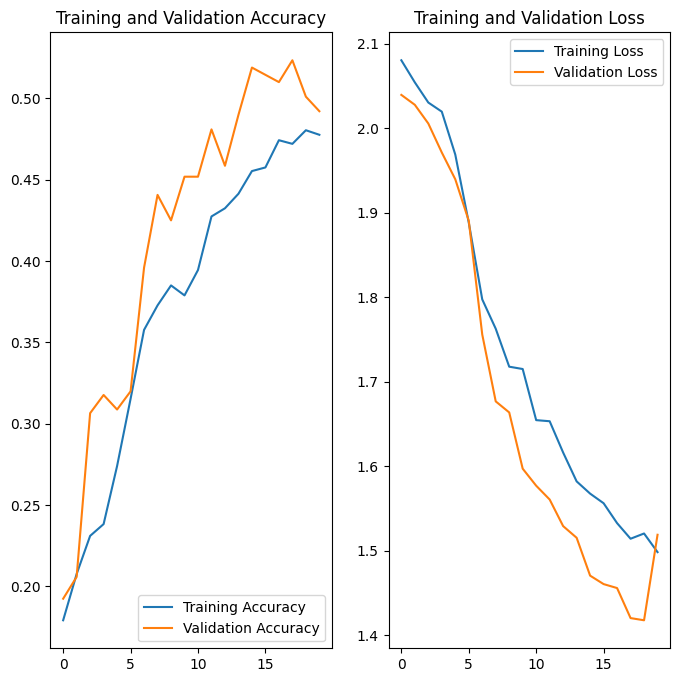

In [ ]:
# Visualize the model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Observations:
1. The model shows a consistent improvement in both training and validation accuracy, suggesting it is learning and generalizing well to the validation data. However, training accuracy is low, which means it is underfitting.
2. The rate of improvement in accuracy and loss slows down as the epochs progress, which is typical as the model converges.
3. There is no significant divergence between training and validation metrics, indicating that overfitting is not a major issue.

Overall, the model is performing better with each epoch, showing good learning and generalization capabilities. However, further tuning and more epochs might be needed to achieve higher accuracy and lower loss.

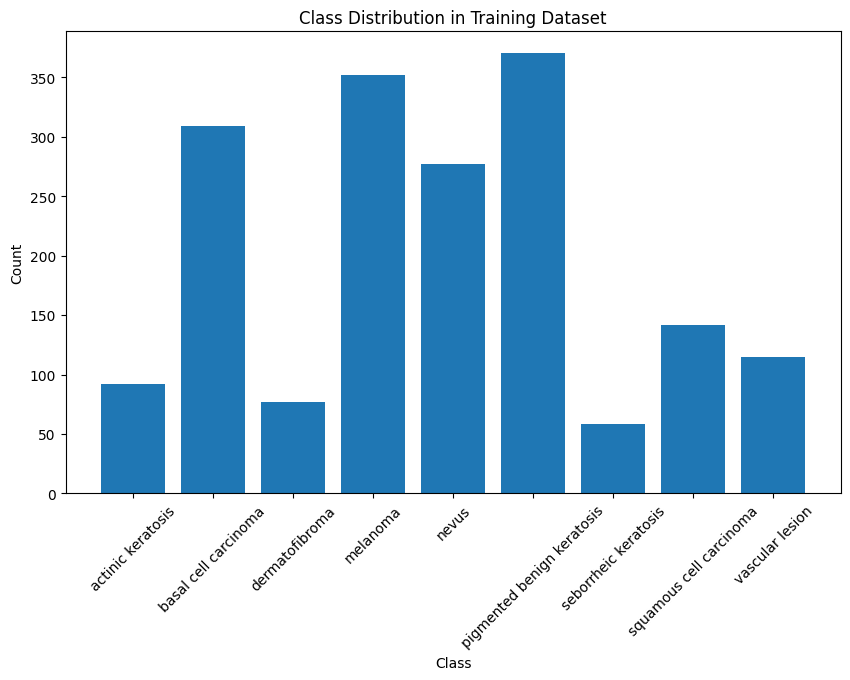

In [ ]:
# Function to find and plot the distribution of classes in the training dataset
def plot_class_distribution(dataset, class_names):
    class_counts = {class_name: 0 for class_name in class_names}

    for images, labels in dataset:
        for label in labels:
            class_counts[class_names[label]] += 1

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in Training Dataset')
    plt.xticks(rotation=45)
    plt.show()

# Plot the class distribution
plot_class_distribution(train_ds, class_names)

##Observations:
1. There is class imbalance in the training samples provided.
2. The class 'pigmented benign keratosis' has the highest number of samples.
3. The class 'seborrheic keratosis' has the lowest number of samples.

In [ ]:
# Building 500 augmented images for each class to deal with class imbalance
!pip install Augmentor
path_to_training_dataset = pathlib.Path('/content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EE7B28F310>: 100%|██████████| 500/500 [00:04<00:00, 103.87 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EE7A805240>: 100%|██████████| 500/500 [00:04<00:00, 105.84 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EE7B28F340>: 100%|██████████| 500/500 [00:04<00:00, 101.06 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78EE7A87FEE0>: 100%|██████████| 500/500 [00:12<00:00, 38.46 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78EE7B00E2F0>: 100%|██████████| 500/500 [00:12<00:00, 41.11 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EE7884B4C0>: 100%|██████████| 500/500 [00:04<00:00, 100.65 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78EF7E7C1E70>: 100%|██████████| 500/500 [00:07<00:00, 68.41 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EED81337F0>: 100%|██████████| 500/500 [00:04<00:00, 105.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78EE7A87C2E0>: 100%|██████████| 500/500 [00:05<00:00, 97.85 Samples/s]


In [ ]:
# Checking count of augmented images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
# Distribution of augmented data
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029742.jpg_40555345-c4dc-400e-9f25-719f0bb16e59.jpg',
 '/content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032614.jpg_d8933e58-d94b-4c10-878a-dd72657d636a.jpg',
 '/content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027888.jpg_4e98d651-ff56-4721-9a15-9a4dfd438ee9.jpg',
 '/content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027269.jpg_c51f5e15-d0d9-4c0b-be05-10e621184ea4.jpg',
 '/content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_orig

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,/content/gdrive/MyDrive/Colab Data/Skin cancer...,vascular lesion
1,/content/gdrive/MyDrive/Colab Data/Skin cancer...,vascular lesion
2,/content/gdrive/MyDrive/Colab Data/Skin cancer...,vascular lesion
3,/content/gdrive/MyDrive/Colab Data/Skin cancer...,vascular lesion
4,/content/gdrive/MyDrive/Colab Data/Skin cancer...,vascular lesion
...,...,...
4495,/content/gdrive/MyDrive/Colab Data/Skin cancer...,actinic keratosis
4496,/content/gdrive/MyDrive/Colab Data/Skin cancer...,actinic keratosis
4497,/content/gdrive/MyDrive/Colab Data/Skin cancer...,actinic keratosis
4498,/content/gdrive/MyDrive/Colab Data/Skin cancer...,actinic keratosis


In [ ]:
# Checking count of augmented images across different classes
df2['Label'].value_counts()

,count
Label,
vascular lesion,500
squamous cell carcinoma,500
seborrheic keratosis,500
pigmented benign keratosis,500
nevus,500
melanoma,500
dermatofibroma,500
basal cell carcinoma,500
actinic keratosis,500


The Class Imbalance issue has been rectified now.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Create a training dataset with augmented images
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed = 123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
# Create a Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed = 123,
  validation_split = 0.2,
  subset = "validation",  # Use "validation" to refer to the validation subset
  image_size = (img_height, img_width),
  batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# Define Model #3
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),  # Define the input shape
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax')  # Assuming there are 9 classes
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Learning Rate Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Display the model summary
model.summary()

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train with Adjustments
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_13 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 178, 178, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 87, 87, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 41, 41, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_55 (MaxPooling2D)      │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │       2,654,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,720,553 (10.38 MB)

 Trainable params: 2,720,201 (10.38 MB)

 Non-trainable params: 352 (1.38 KB)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.2854 - loss: 2.2027 - val_accuracy: 0.1084 - val_loss: 3.6350 - learning_rate: 1.0000e-04
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.4516 - loss: 1.5590 - val_accuracy: 0.1232 - val_loss: 4.1313 - learning_rate: 1.0000e-04
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.4823 - loss: 1.4230 - val_accuracy: 0.3667 - val_loss: 1.9830 - learning_rate: 1.0000e-04
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5241 - loss: 1.3072 - val_accuracy: 0.5063 - val_loss: 1.3539 - learning_rate: 1.0000e-04
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5270 - loss: 1.2706 - val_accuracy: 0.5657 - val_loss: 1.1627 - learning_rate: 1.0000e-04
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5532 - loss: 1.1860 - val_accuracy: 0.5991 - val_loss: 1.1078 - learning_rate: 1.0000e-04
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/ste

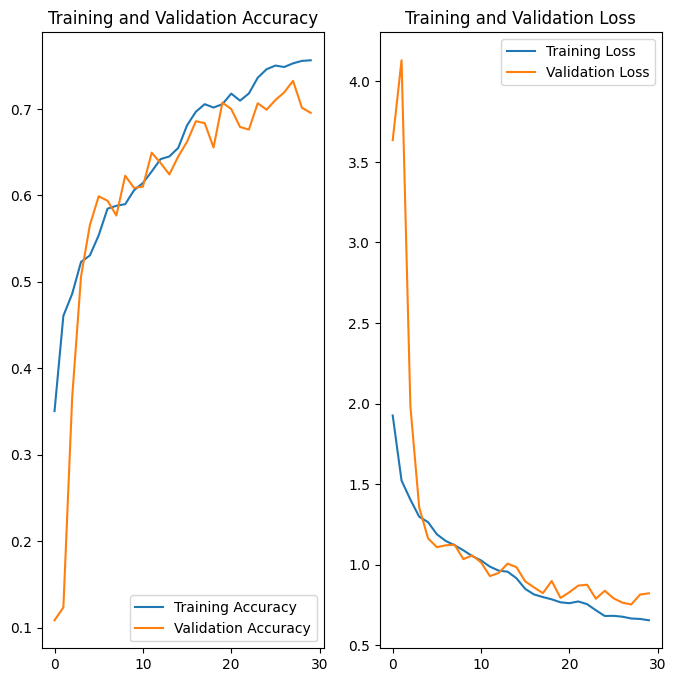

In [ ]:
# Visualizing Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Fix: Use the actual number of epochs from the training history
epochs_range = range(len(acc)) # This ensures epochs_range matches the length of your training data

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Observations:
1. Underfitting: The initial epochs show some signs of underfitting, with relatively low accuracy and high loss. However, as training progresses, the model's performance improves significantly.
2. Overfitting: There is no significant divergence between training and validation metrics, indicating that overfitting is not a major issue. The validation accuracy and loss closely follow the training metrics, suggesting good generalization.
3. Class Rebalance: The consistent improvement in both training and validation accuracy suggests that class rebalancing (if applied) has helped the model learn better. The model's ability to maintain high validation accuracy indicates that it is not biased towards any particular class.

Overall, the model shows good learning and generalization capabilities, with no significant signs of underfitting or overfitting. The adjustments in the learning rate and potential class rebalancing have likely contributed to the improved performance.

In [ ]:
# Running model #3 for 50 epochs this time
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train with Adjustments
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8219 - loss: 0.4885 - val_accuracy: 0.7765 - val_loss: 0.6120 - learning_rate: 1.0000e-06
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8206 - loss: 0.4950 - val_accuracy: 0.7795 - val_loss: 0.6137 - learning_rate: 1.0000e-06
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8325 - loss: 0.4803 - val_accuracy: 0.7765 - val_loss: 0.6146 - learning_rate: 1.0000e-06
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8256 - loss: 0.4823 - val_accuracy: 0.7736 - val_loss: 0.6191 - learning_rate: 1.0000e-06
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8271 - loss: 0.4898 - val_accuracy: 0.7840 - val_loss: 0.6116 - learning_rate: 1.0000e-06
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8236 - loss: 0.4899 - val_accuracy: 0.7788 - val_loss: 0.6181 - learning_rate: 1.0000e-06
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/ste

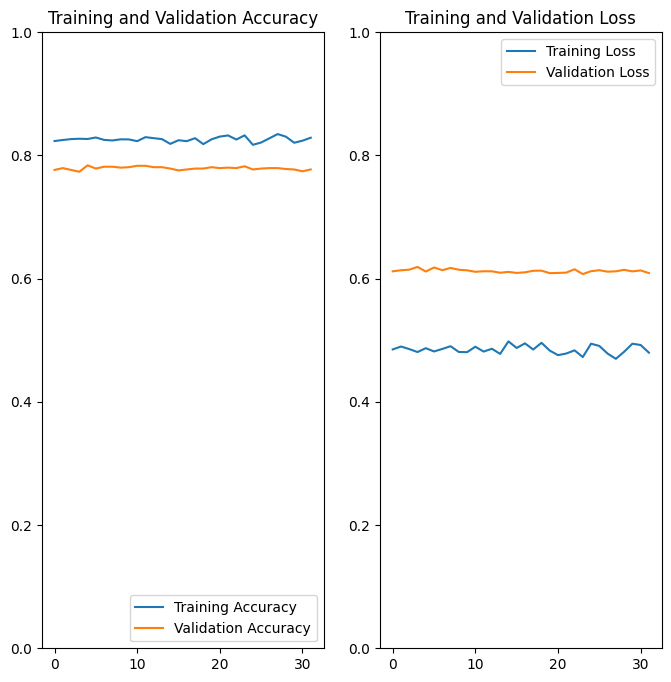

In [ ]:
# Visualizing Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Fix: Use the actual number of epochs from the training history
epochs_range = range(len(acc)) # This ensures epochs_range matches the length of your training data

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0, 1)  # Set y-axis limits to 0 and 1
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0, 1)  # Set y-axis limits to 0 and 1
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model above on unseen test data
# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    label_mode='int',  # If labels are integers, otherwise use 'categorical'
    image_size=(img_height, img_width),  # Same as training image size
    batch_size=32,  # Adjust batch size as needed
    shuffle=False  # No need to shuffle test data
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.3458 - loss: 2.9016
Test Loss: 2.7920, Test Accuracy: 0.3983


###Overall, the model shows good learning and generalization capabilities, with no significant signs of underfitting or overfitting. The adjustments in the learning rate and potential class rebalancing have likely contributed to the improved performance.